In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 35.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-pspjq7ha
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-pspjq7ha
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit 845c5cffc086c0a37dd3255d5f9219d982439efe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt

from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from torch import distributions
import torch_geometric
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
import csv
from time import perf_counter

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
#from torch_geometric.explain import Explainer, GNNExplainer
import torch_geometric.nn as gnn
from time import perf_counter
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
import random
from functools import cached_property
from typing import Optional, Literal
import networkx as nx
import pandas as pd
from tqdm.auto import tqdm
import secrets
import os
import pickle
import glob

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mutag_dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [5]:
Explainability_name = 'GNNInterpreter'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GIN"
DataSet_name = "MUTAG"

File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [6]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

mutag_train_dataset = []
mutag_test_dataset = []
for index in read_training_list_indexes:
    mutag_train_dataset.append(mutag_dataset[index])
for index in read_test_list_indexes:
    mutag_test_dataset.append(mutag_dataset[index])


print(f'Number of training graphs: {len(mutag_train_dataset)}')
print(f'Number of test graphs: {len(mutag_test_dataset)}')

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]
Number of training graphs: 150
Number of test graphs: 38


In [7]:
BATCH_SIZE = 64
mutag_train_dataloader = DataLoader(mutag_train_dataset, batch_size=BATCH_SIZE, shuffle=False) # important to be false
mutag_test_dataloader = DataLoader(mutag_test_dataset, batch_size=1, shuffle=False)

In [8]:
from torch_geometric.datasets import FakeDataset

num_graphs = 100
avg_num_nodes = 20
avg_degree = 15
node_feat_dim = 13
edge_feat_dim = 0
num_classes = 3

fake_dataset = FakeDataset(num_graphs=num_graphs, avg_num_nodes=avg_num_nodes, avg_degree=avg_degree, num_channels=node_feat_dim,
                           edge_dim=edge_feat_dim, num_classes=num_classes,)
Explainability_name = 'GNNInterpreter'
Task_name = 'Graph Classification'
classifier_bias = True
DataSet_name = "Fake"
BATCH_SIZE = 10
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6

train_ratio = 0.8

fake_train_dataset = fake_dataset[:int(len(fake_dataset) * train_ratio)]
fake_test_dataset = fake_dataset[len(fake_dataset) - int(len(fake_dataset) * train_ratio):]

fake_train_dataloader = DataLoader(fake_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
fake_test_dataloader = DataLoader(fake_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GIN as gin_model
GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=7, mlp_hid_dim=7,
                                mlp_output_dim=2, mlp_act_fun="ReLu", dropout_rate=classifier_dropout,
                                Weight_Initializer=3, joint_embeddings=False)

In [10]:
print(GNN_Model)

GIN_Model(
  (gin_mlp_layers): ModuleList(
    (0-3): 4 x GIN_MLPs(
      (gin_mlp_layers): ModuleList(
        (0-1): 2 x Linear(in_features=7, out_features=7, bias=True)
      )
      (gin_batch_normalization): ModuleList(
        (0-1): 2 x BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (global_summing): GlobalSUMPool()
  (the_first_layer): Linear(in_features=7, out_features=7, bias=True)
  (lin1): Linear(in_features=7, out_features=7, bias=True)
  (lin2): Linear(in_features=7, out_features=2, bias=True)
  (dorpout): Dropout(p=0.1, inplace=False)
)


In [11]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [12]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [13]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()


In [14]:
def train_step(data):
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in data:

        mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
        batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
        Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [15]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index, data):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step(data)
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 0.7922
Epoch: 002, Model Loss: 0.7657
Epoch: 003, Model Loss: 0.7389
Epoch: 004, Model Loss: 0.7125
Epoch: 005, Model Loss: 0.7139
Epoch: 006, Model Loss: 0.7096
Epoch: 007, Model Loss: 0.6955
Epoch: 008, Model Loss: 0.6890
Epoch: 009, Model Loss: 0.6799
Epoch: 010, Model Loss: 0.6708
Epoch: 011, Model Loss: 0.6600
Epoch: 012, Model Loss: 0.6444
Epoch: 013, Model Loss: 0.6234
Epoch: 014, Model Loss: 0.6257
Epoch: 015, Model Loss: 0.6056
Epoch: 016, Model Loss: 0.5920
Epoch: 017, Model Loss: 0.5850
Epoch: 018, Model Loss: 0.5791
Epoch: 019, Model Loss: 0.5811
Epoch: 020, Model Loss: 0.5710
Epoch: 021, Model Loss: 0.5629
Epoch: 022, Model Loss: 0.5512
Epoch: 023, Model Loss: 0.5437
Epoch: 024, Model Loss: 0.5324
Epoch: 025, Model Loss: 0.5585
Epoch: 026, Model Loss: 0.5219
Epoch: 027, Model Loss: 0.5245
Epoch: 028, Model Loss: 0.5240
Epoch: 029, Model Loss: 0.5241
Epoch: 030, Model Loss: 0.5240
Epoch: 031, Model Loss: 0.5323
Epoch: 032, Model Loss: 0.5064
Epoch: 0

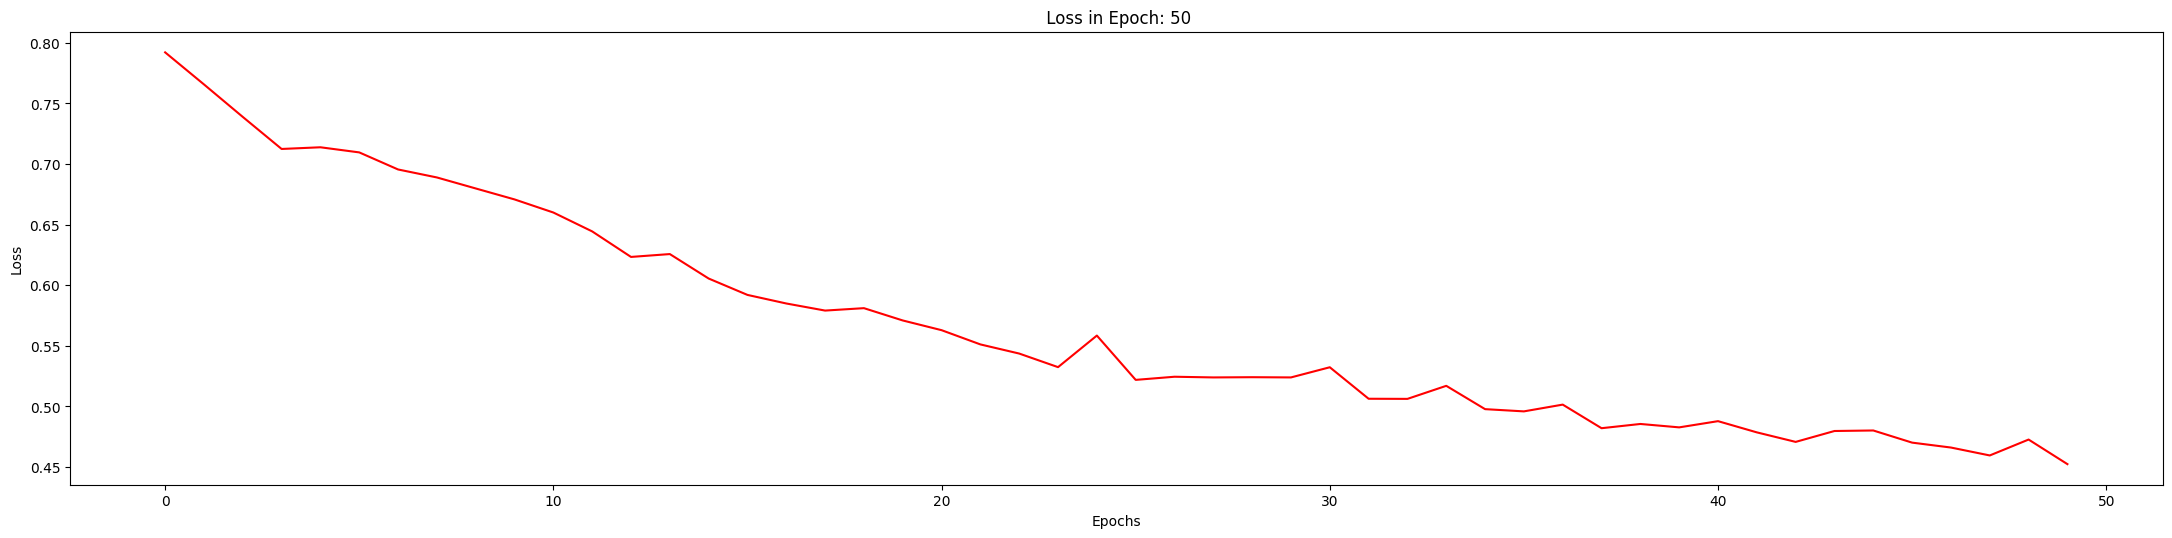

Epoch: 051, Model Loss: 0.4543
Epoch: 052, Model Loss: 0.4460
Epoch: 053, Model Loss: 0.4328
Epoch: 054, Model Loss: 0.4448
Epoch: 055, Model Loss: 0.4376
Epoch: 056, Model Loss: 0.4327
Epoch: 057, Model Loss: 0.4313
Epoch: 058, Model Loss: 0.4333
Epoch: 059, Model Loss: 0.4299
Epoch: 060, Model Loss: 0.4235
Epoch: 061, Model Loss: 0.4137
Epoch: 062, Model Loss: 0.4268
Epoch: 063, Model Loss: 0.4197
Epoch: 064, Model Loss: 0.4099
Epoch: 065, Model Loss: 0.4109
Epoch: 066, Model Loss: 0.4081
Epoch: 067, Model Loss: 0.4178
Epoch: 068, Model Loss: 0.4070
Epoch: 069, Model Loss: 0.4039
Epoch: 070, Model Loss: 0.3967
Epoch: 071, Model Loss: 0.4070
Epoch: 072, Model Loss: 0.3874
Epoch: 073, Model Loss: 0.3913
Epoch: 074, Model Loss: 0.3850
Epoch: 075, Model Loss: 0.3914
Epoch: 076, Model Loss: 0.3852
Epoch: 077, Model Loss: 0.3790
Epoch: 078, Model Loss: 0.3722
Epoch: 079, Model Loss: 0.3833
Epoch: 080, Model Loss: 0.3790
Epoch: 081, Model Loss: 0.3846
Epoch: 082, Model Loss: 0.3863
Epoch: 0

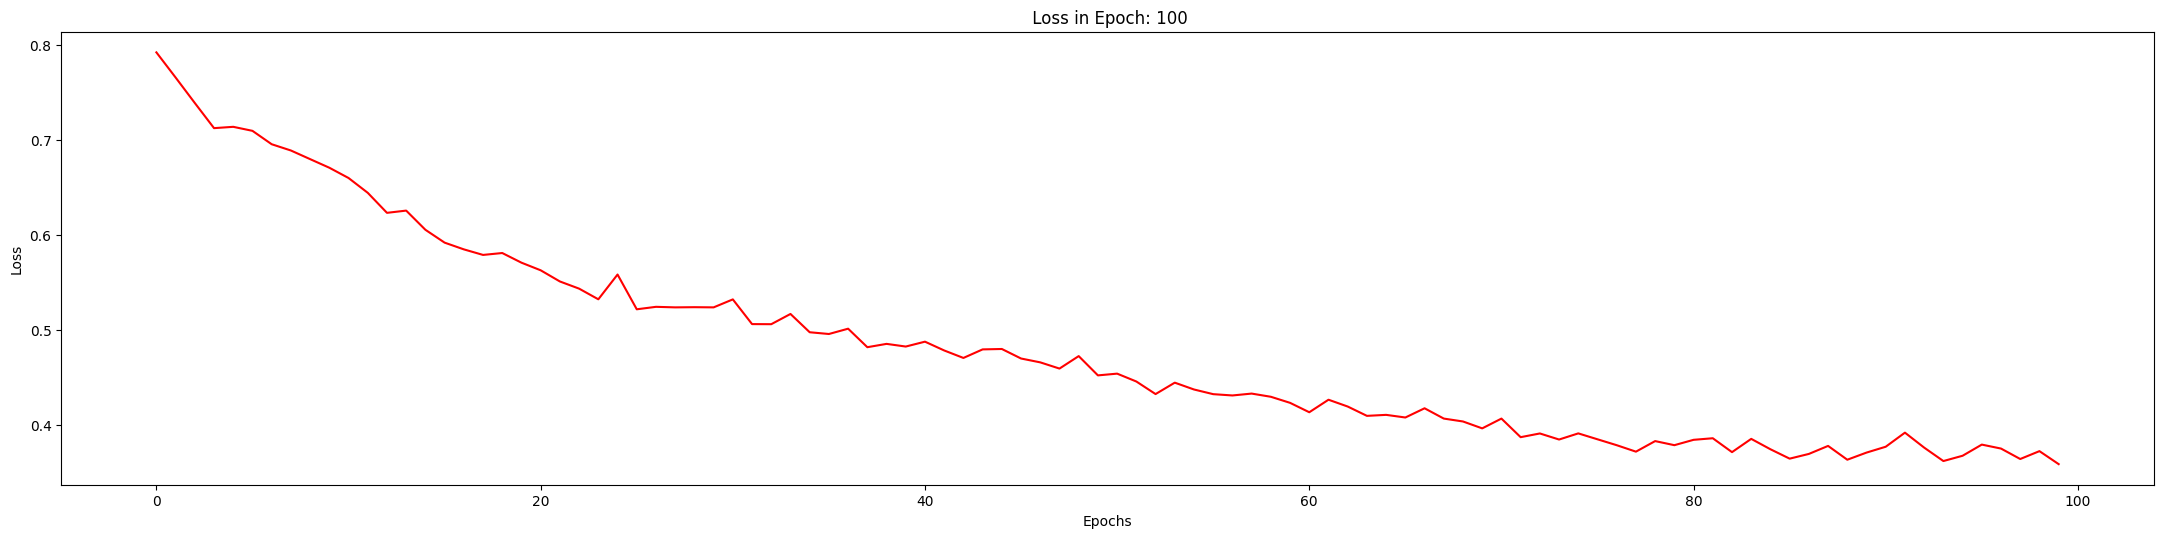

Epoch: 101, Model Loss: 0.3726
Epoch: 102, Model Loss: 0.3524
Epoch: 103, Model Loss: 0.3537
Epoch: 104, Model Loss: 0.3613
Epoch: 105, Model Loss: 0.3600
Epoch: 106, Model Loss: 0.3526
Epoch: 107, Model Loss: 0.3589
Epoch: 108, Model Loss: 0.3546
Epoch: 109, Model Loss: 0.3511
Epoch: 110, Model Loss: 0.3557
Epoch: 111, Model Loss: 0.3545
Epoch: 112, Model Loss: 0.3543
Epoch: 113, Model Loss: 0.3605
Epoch: 114, Model Loss: 0.3494
Epoch: 115, Model Loss: 0.3554
Epoch: 116, Model Loss: 0.3503
Epoch: 117, Model Loss: 0.3629
Epoch: 118, Model Loss: 0.3499
Epoch: 119, Model Loss: 0.3485
Epoch: 120, Model Loss: 0.3497
Epoch: 121, Model Loss: 0.3505
Epoch: 122, Model Loss: 0.3524
Epoch: 123, Model Loss: 0.3557
Epoch: 124, Model Loss: 0.3472
Epoch: 125, Model Loss: 0.3446
Epoch: 126, Model Loss: 0.3581
Epoch: 127, Model Loss: 0.3411
Epoch: 128, Model Loss: 0.3402
Epoch: 129, Model Loss: 0.3421
Epoch: 130, Model Loss: 0.3399
Epoch: 131, Model Loss: 0.3503
Epoch: 132, Model Loss: 0.3526
Epoch: 1

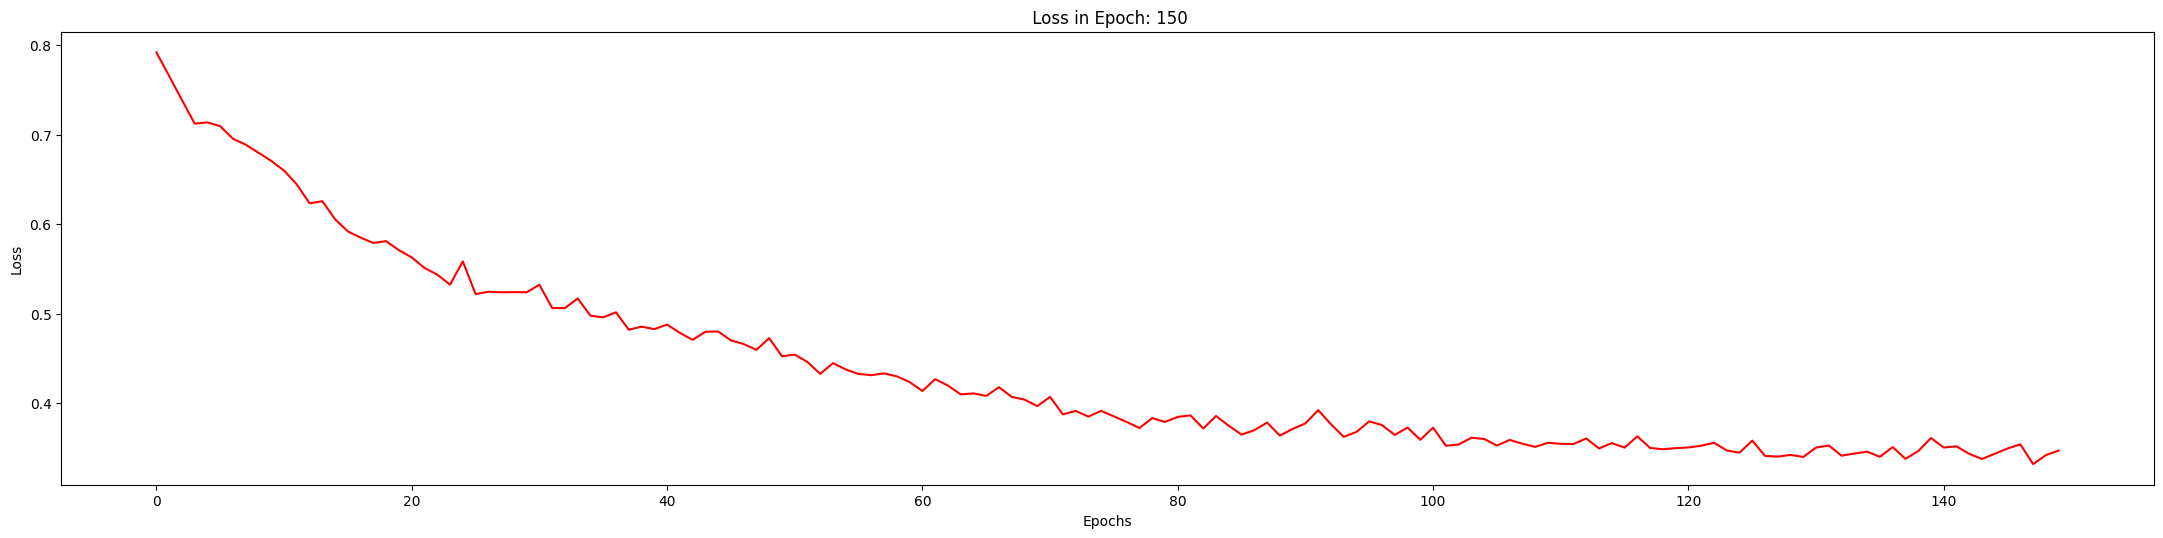

Epoch: 151, Model Loss: 0.3422
Epoch: 152, Model Loss: 0.3422
Epoch: 153, Model Loss: 0.3489
Epoch: 154, Model Loss: 0.3479
Epoch: 155, Model Loss: 0.3431
Epoch: 156, Model Loss: 0.3520
Epoch: 157, Model Loss: 0.3454
Epoch: 158, Model Loss: 0.3388
Epoch: 159, Model Loss: 0.3542
Epoch: 160, Model Loss: 0.3432
Epoch: 161, Model Loss: 0.3423
Epoch: 162, Model Loss: 0.3380
Epoch: 163, Model Loss: 0.3395
Epoch: 164, Model Loss: 0.3394
Epoch: 165, Model Loss: 0.3467
Epoch: 166, Model Loss: 0.3401
Epoch: 167, Model Loss: 0.3405
Epoch: 168, Model Loss: 0.3501
Epoch: 169, Model Loss: 0.3344
Epoch: 170, Model Loss: 0.3565
Epoch: 171, Model Loss: 0.3409
Epoch: 172, Model Loss: 0.3578
Epoch: 173, Model Loss: 0.3432
Epoch: 174, Model Loss: 0.3579
Epoch: 175, Model Loss: 0.3513
Epoch: 176, Model Loss: 0.3511
Epoch: 177, Model Loss: 0.3532
Epoch: 178, Model Loss: 0.3521
Epoch: 179, Model Loss: 0.3383
Epoch: 180, Model Loss: 0.3487
Epoch: 181, Model Loss: 0.3336
Epoch: 182, Model Loss: 0.3383
Epoch: 1

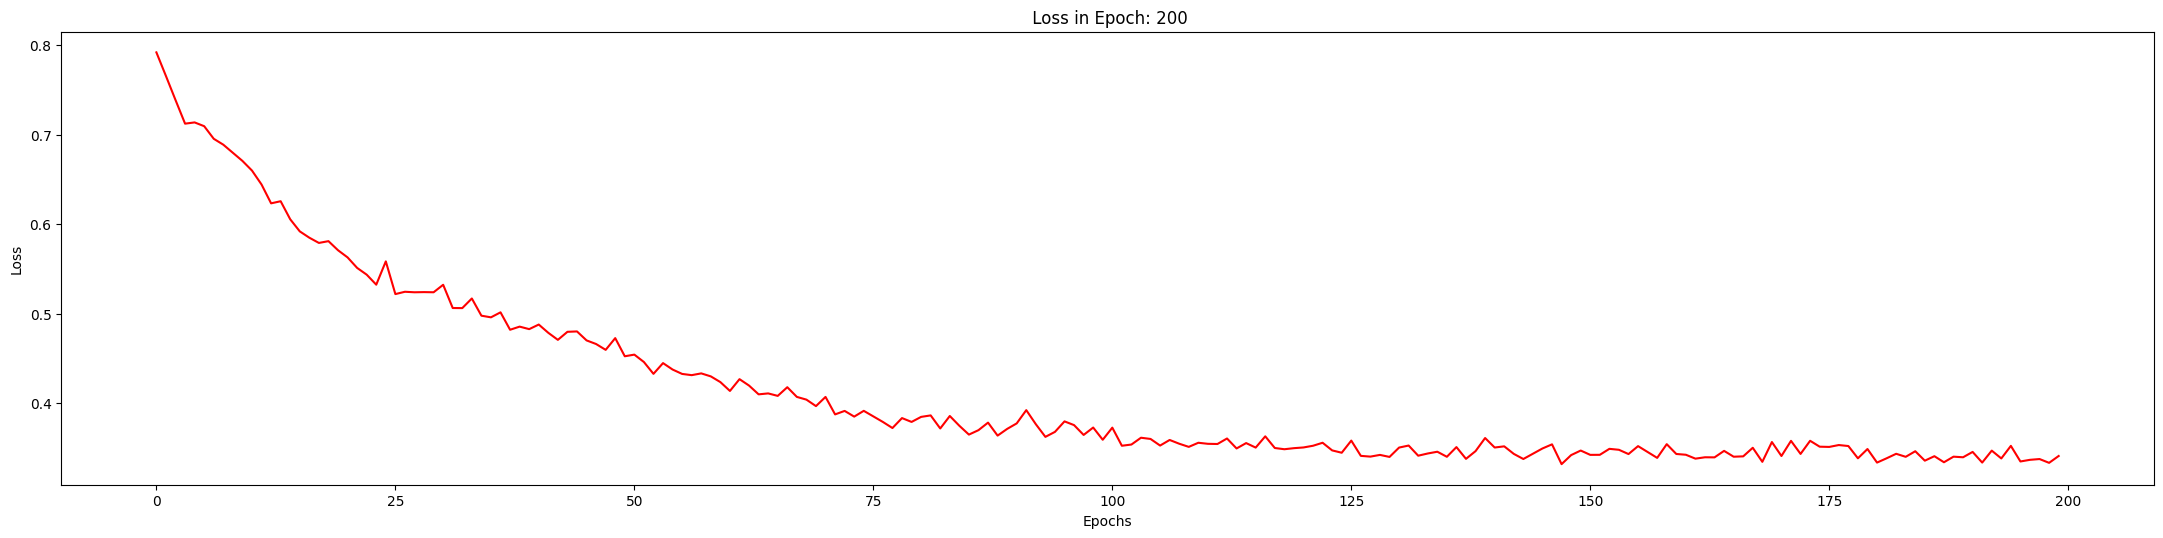

Epoch: 201, Model Loss: 0.3466
Epoch: 202, Model Loss: 0.3414
Epoch: 203, Model Loss: 0.3460
Epoch: 204, Model Loss: 0.3457
Epoch: 205, Model Loss: 0.3568
Epoch: 206, Model Loss: 0.3502
Epoch: 207, Model Loss: 0.3583
Epoch: 208, Model Loss: 0.3528
Epoch: 209, Model Loss: 0.3478
Epoch: 210, Model Loss: 0.3460
Epoch: 211, Model Loss: 0.3452
Epoch: 212, Model Loss: 0.3363
Epoch: 213, Model Loss: 0.3369
Epoch: 214, Model Loss: 0.3493
Epoch: 215, Model Loss: 0.3483
Epoch: 216, Model Loss: 0.3427
Epoch: 217, Model Loss: 0.3471
Epoch: 218, Model Loss: 0.3428
Epoch: 219, Model Loss: 0.3485
Epoch: 220, Model Loss: 0.3435
Epoch: 221, Model Loss: 0.3366
Epoch: 222, Model Loss: 0.3326
Epoch: 223, Model Loss: 0.3385
Epoch: 224, Model Loss: 0.3436
Epoch: 225, Model Loss: 0.3475
Epoch: 226, Model Loss: 0.3364
Epoch: 227, Model Loss: 0.3522
Epoch: 228, Model Loss: 0.3539
Epoch: 229, Model Loss: 0.3673
Epoch: 230, Model Loss: 0.3478
Epoch: 231, Model Loss: 0.3517
Epoch: 232, Model Loss: 0.3510
Epoch: 2

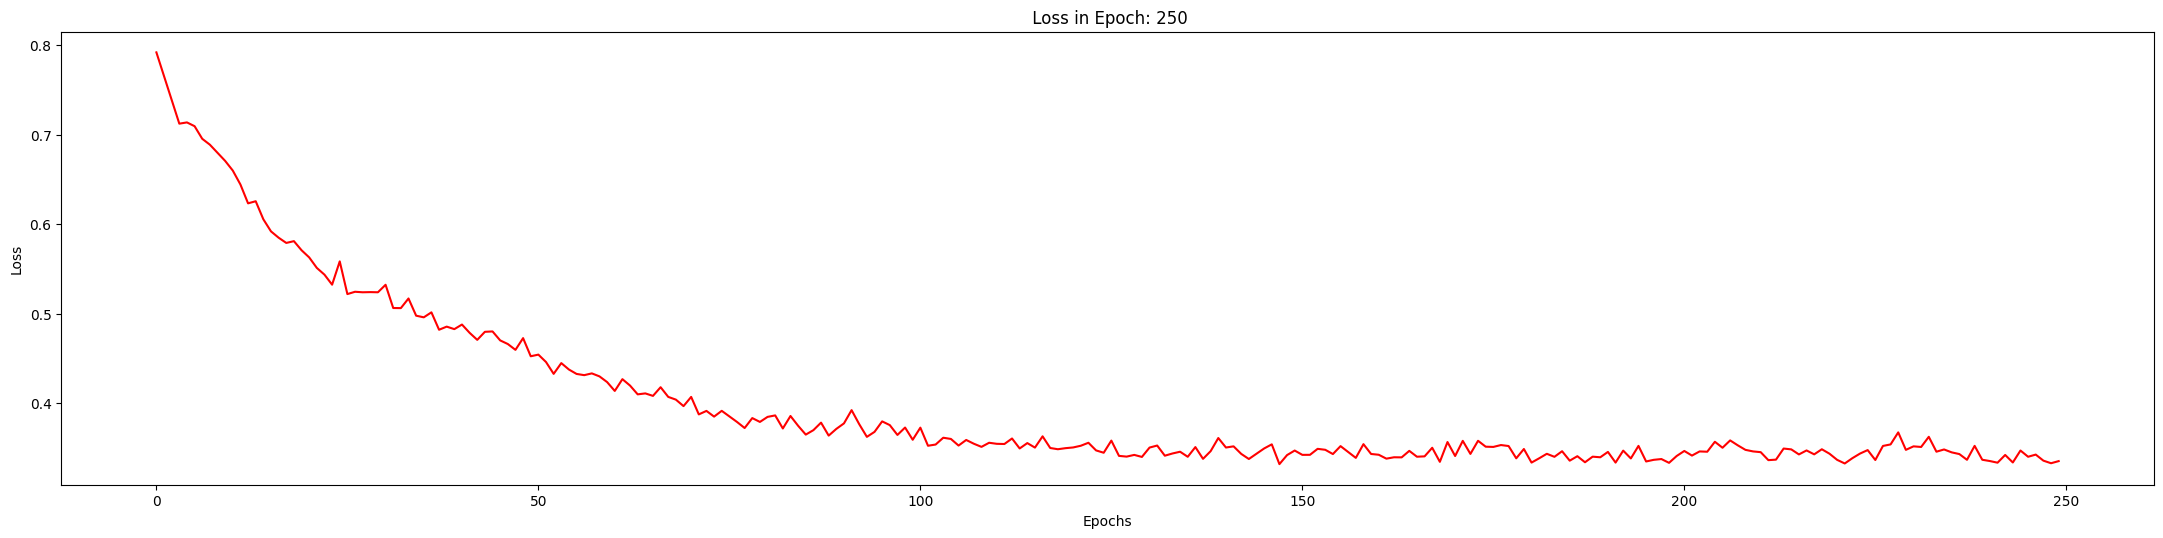

Epoch: 251, Model Loss: 0.3255
Epoch: 252, Model Loss: 0.3328
Epoch: 253, Model Loss: 0.3362
Epoch: 254, Model Loss: 0.3381
Epoch: 255, Model Loss: 0.3326
Epoch: 256, Model Loss: 0.3418
Epoch: 257, Model Loss: 0.3309
Epoch: 258, Model Loss: 0.3284
Epoch: 259, Model Loss: 0.3316
Epoch: 260, Model Loss: 0.3413
Epoch: 261, Model Loss: 0.3365
Epoch: 262, Model Loss: 0.3322
Epoch: 263, Model Loss: 0.3317
Epoch: 264, Model Loss: 0.3354
Epoch: 265, Model Loss: 0.3339
Epoch: 266, Model Loss: 0.3413
Epoch: 267, Model Loss: 0.3450
Epoch: 268, Model Loss: 0.3301
Epoch: 269, Model Loss: 0.3365
Epoch: 270, Model Loss: 0.3329
Epoch: 271, Model Loss: 0.3261
Epoch: 272, Model Loss: 0.3401
Epoch: 273, Model Loss: 0.3308
Epoch: 274, Model Loss: 0.3370
Epoch: 275, Model Loss: 0.3385
Epoch: 276, Model Loss: 0.3332
Epoch: 277, Model Loss: 0.3310
Epoch: 278, Model Loss: 0.3417
Epoch: 279, Model Loss: 0.3301
Epoch: 280, Model Loss: 0.3281
Epoch: 281, Model Loss: 0.3298
Epoch: 282, Model Loss: 0.3429
Epoch: 2

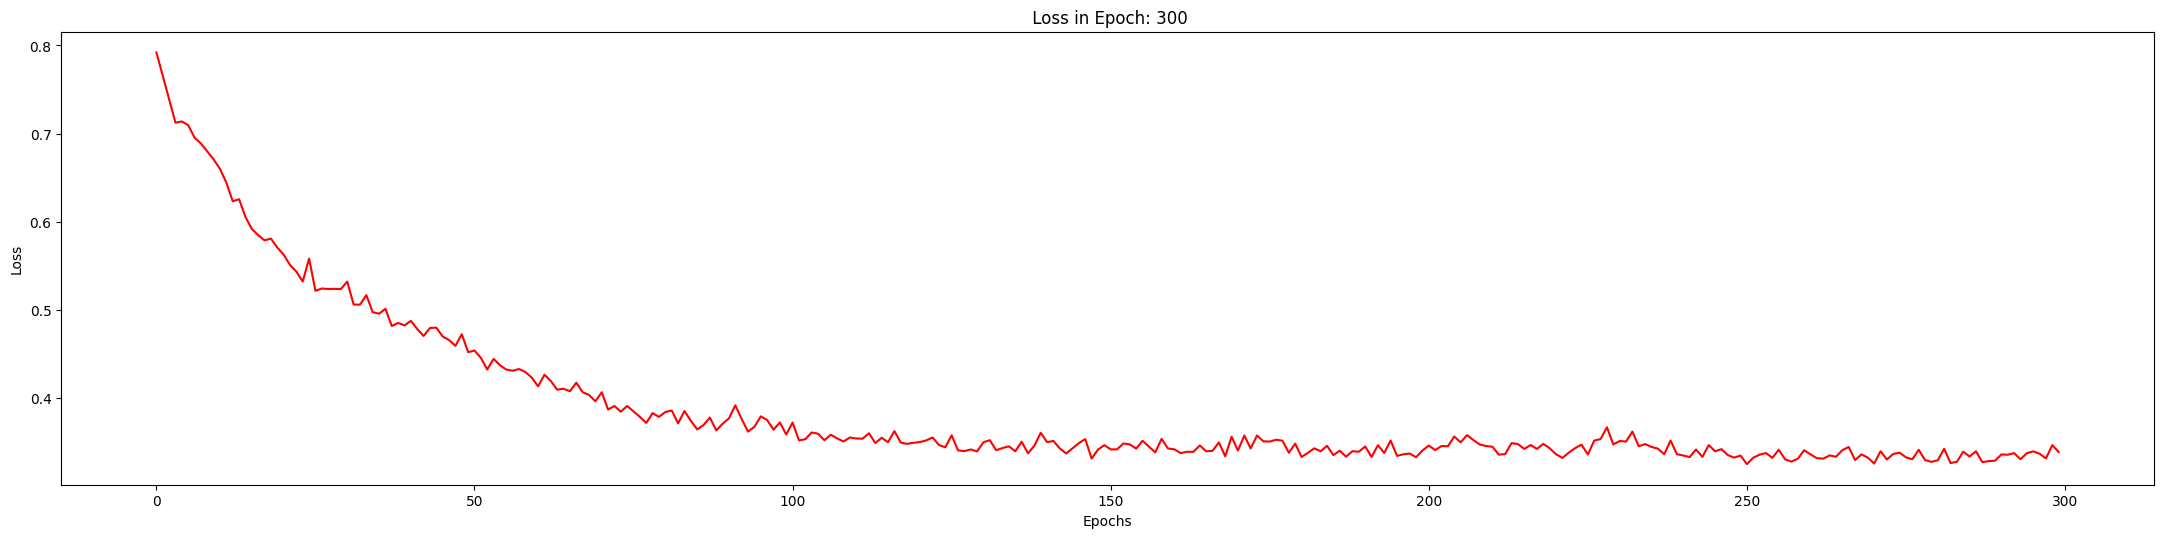

In [16]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index, mutag_train_dataloader)

## **Test**

In [17]:
def GNN_Model_test(test_data):
    predictions = []
    GNN_Model.eval()

    correct = 0
    for batch_of_graphs in test_data:
        mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batch_of_graphs, None)
        GNN_Model_test_pred = soft.argmax(dim=1)
        predictions.append(GNN_Model_test_pred.tolist()[0])

        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())

    return correct / len(test_data), predictions

In [18]:
GNN_Model_test_acc, predictions = GNN_Model_test(mutag_test_dataset)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')

Test Accuracy: 0.6842


## **GNNInterpreter**

In [19]:
class Graph_Generator(nn.Module):
    def __init__(self, max_nodes, num_node_classes, num_edge_classes, nodes, edges, Graph, learning_node_feat, learning_edge_feat,
                 temperature):
        super().__init__()
        if Graph:
            Graph = nx.convert_node_labels_to_integers(Graph)
            nodes = [Graph.nodes[i]['label'] for i in range(Graph.number_of_nodes())]
            edges = Graph.edges

        self.num_nodes = max_nodes or len(nodes)
        self.num_node_classes = num_node_classes or (max(nodes) if nodes is not None else 1)
        self.num_edge_classes = num_edge_classes

        self.nodes = nodes or self.generate_a_list_of_n_random_values_from_k_classes(self.num_nodes, self.num_node_classes)
        self.edges = edges or self.generate_edges_for_a_complete_graph(self.num_nodes)
        self.edge_classes = self.generate_a_list_of_n_random_values_from_k_classes(self.num_edges, self.num_edge_classes) if num_edge_classes else None
        self.tau = temperature

        #################################                       DEFINE Parameters
        self.param_list = []

        # for edge existance
        self.edge_parameters = nn.Parameter(torch.empty(self.num_edges))                                         #omega
        self.param_list.extend(["edge_parameters", "apply_sigmoid_on_edge_parameters", "edge_parameters_pairs_of_nodes"])

        # for node existance
        if learning_node_feat:
            self.node_feature_parameters = nn.Parameter(torch.empty(self.num_nodes, self.num_node_classes))      #xi
            self.param_list.extend(["node_feature_parameters", "softmax_node_feature_parameters"])
        else:
            self.node_feature_parameters = None

        # for edge feature
        if learning_edge_feat:
            self.edge_feature_parameters = nn.Parameter(torch.empty(self.num_edges, self.num_edge_classes))      #eta
            self.param_list.extend(["edge_feature_parameters", "softmax_edge_feature_parameters"])
        else:
            self.edge_feature_parameters = None

        self.init()

    @torch.no_grad()
    def init(self, Graph=None):
        eps= 1e-4
        #                                                               For Edge Existance, theta: fuzzy values for edges: weights
        if Graph is None:
            theta = torch.rand(self.num_edges)
        else:
            theta_list = []
            for u, v in self.create_edge_index.T[:self.num_edges].tolist():
                if (u, v) in Graph.edges or (v, u) in Graph.edges:
                    theta_list.append(1 - eps)
                else:
                    theta_list.append(eps)
            theta = torch.stack(theta_list)

        self.edge_parameters.data = torch.logit(theta)

        #                                                               For Node Class
        if self.node_feature_parameters is not None:
            if Graph is None:
                p = distributions.Dirichlet(torch.ones(self.num_node_classes)).sample([self.num_nodes])
            else:
                for i in Graph.nodes:
                    p = torch.stack([(torch.eye(self.num_node_classes) * (1 - 2*eps) + eps)[Graph.nodes[i]['label']] ])

            self.node_feature_parameters.data = torch.log(p)

        #                                                               For Edge Class
        if self.edge_feature_parameters is not None:
            if Graph is None:
                q = distributions.Dirichlet(torch.ones(self.num_edge_classes)).sample([self.num_edges])
            else:
                q_list = []
                for u, v in self.create_edge_index.T[:self.num_edges].tolist():
                    if (u, v) in Graph.edges:
                        q_list.append((torch.eye(self.num_edge_classes) * (1 - 2*eps) + eps)[Graph.edges[(u, v)]['label']])
                    else:
                        if (v, u) in Graph.edges:
                            q_list.append((torch.eye(self.num_edge_classes) * (1 - 2*eps) + eps)[Graph.edges[(v, u)]['label']])
                        else:
                            q_list.append(torch.zeros(self.num_edge_classes) + eps)
                q = torch.stack(q_list)

            self.edge_feature_parameters.data = torch.log(q)

    @staticmethod
    def generate_a_list_of_n_random_values_from_k_classes(number_of_rows, number_of_columns):
        return random.choices(range(number_of_columns), k=number_of_rows)

    @staticmethod
    def generate_edges_for_a_complete_graph(n):
        return [(i, j) for i in range(n) for j in range(n) if i < j]

    @cached_property
    def num_edges(self):
        return len(self.edges)

    @cached_property
    def create_edge_index(self) -> torch.Tensor:
        edges = ([(i, j) for i, j in self.edges] +
                 [(j, i) for i, j in self.edges])
        assert len(edges) == self.num_edges * 2
        return torch.tensor(edges).T

    def sample_epsilon(self, target, seed=None, if_not_seed_equal_chance=False):
        if if_not_seed_equal_chance:
            return torch.ones_like(target) / 2
        else:
            if seed is not None:
                torch.manual_seed(seed)
            else:
                torch.seed()
            return torch.rand_like(target)

    def sample_Adjacency(self, seed=None, if_not_seed_equal_chance=False):
        #   Equation 5th
        eps = self.sample_epsilon(self.edge_parameters, seed=seed, if_not_seed_equal_chance=if_not_seed_equal_chance)
        logistic = torch.logit(eps)
        A = torch.sigmoid((self.edge_parameters + logistic) / self.tau)
        return torch.cat([A, A], dim=0)

    def sample_Node_Features(self, seed=None, if_not_seed_equal_chance=False):
        #   Equation 5th
        if self.node_feature_parameters is not None:
            eps = self.sample_epsilon(self.node_feature_parameters, seed=seed, if_not_seed_equal_chance=if_not_seed_equal_chance)
            gumbel = -torch.log(-torch.log(eps))
            X = torch.softmax((self.node_feature_parameters + gumbel) / self.tau, dim=1)
            return X
        else:
            return torch.eye(self.k)[self.nodes]

    def sample_Edge_Features(self, seed=None, if_not_seed_equal_chance=False):
        #   Equation 5th
        if self.edge_feature_parameters is not None:
            eps = self.sample_epsilon(self.edge_feature_parameters, seed=seed, if_not_seed_equal_chance=if_not_seed_equal_chance)
            gumbel = -torch.log(-torch.log(eps))
            E = torch.softmax((self.edge_feature_parameters + gumbel) / self.tau, dim=1)
        elif self.num_edge_classes:
            E = torch.eye(self.num_edge_classes)[self.edge_classes]
        else:
            return None
        return torch.cat([E, E], dim=0)

    @property
    def edge_parameters_pairs_of_nodes(self):
        return self.apply_sigmoid_on_edge_parameters[self.edge_parameters.long()]

    def attributes_into_dict(self):
        my_dict = {}
        for item in self.param_list:
            my_dict[item] = getattr(self, item)
        return my_dict

    @property
    def softmax_node_feature_parameters(self):
        return torch.softmax(self.node_feature_parameters, dim=1)

    @property
    def softmax_edge_feature_parameters(self):
        return torch.softmax(self.edge_feature_parameters, dim=1)

    @property
    def apply_sigmoid_on_edge_parameters(self):
        return torch.sigmoid(self.edge_parameters)

    @cached_property
    def pair_index_for_each_edge(self):
        edges = self.edge_index.T[:self.num_edges]
        pairs = [(i, j)
                 for i in range(self.num_edges-1)
                 for j in range(i+1, self.num_edges)
                 if edges[i][0] == edges[j][0]]
        return torch.tensor(pairs).T

    @property
    def expected_number_of_edges_in_the_generated_graph(self):
        return self.apply_sigmoid_on_edge_parameters.sum().item()

    def forward(self, batch_size_for_same_sized_graphs, mode, seed, if_not_seed_equal_chance):

        X = self.sample_Node_Features(seed=seed, if_not_seed_equal_chance=if_not_seed_equal_chance)
        A = self.sample_Adjacency(seed=seed, if_not_seed_equal_chance=if_not_seed_equal_chance)     # With Respect to Edge Weight.
        E = self.sample_Edge_Features(seed=seed, if_not_seed_equal_chance=if_not_seed_equal_chance)
        continuous_data, discrete_data = None, None

        if mode in ['continuous', 'both']:
            data_list = []
            for _ in range(batch_size_for_same_sized_graphs):
                data_list.append(torch_geometric.data.Data(x=X, edge_index=self.create_edge_index, edge_weight=A, edge_attr=E))
            continuous_data = torch_geometric.data.Batch.from_data_list(data_list)

        if mode in ['discrete', 'both']:
            edge_attr_list = []
            for _ in range(batch_size_for_same_sized_graphs):
                if self.edge_feature_parameters is not None:
                    edge_attr_list.append(torch_geometric.data.Data(x=torch.eye(self.num_node_classes)[X.argmax(dim=-1)].float(),
                                                        edge_index=self.create_edge_index, edge_weight=(A > 0.5).float(),
                                                        edge_attr=torch.eye(self.num_edge_classes)[E.argmax(dim=-1)].float()))
                else:
                    edge_attr_list.append(torch_geometric.data.Data(x=torch.eye(self.num_node_classes)[X.argmax(dim=-1)].float(),
                                                        edge_index=self.create_edge_index, edge_weight=(A > 0.5).float(),
                                                        edge_attr=E))

            discrete_data = torch_geometric.data.Batch.from_data_list(edge_attr_list)

        if mode == 'both':
            return continuous_data, discrete_data

        elif mode == 'continuous':
            return continuous_data

        elif mode == 'discrete':
            return discrete_data

In [20]:
generator = Graph_Generator(max_nodes=10, num_node_classes=7, num_edge_classes=4, nodes=None, edges=None, Graph=None,
                            learning_node_feat=True, learning_edge_feat=False, temperature=1)

generated_graph = generator(batch_size_for_same_sized_graphs=1, mode='discrete', seed=None, if_not_seed_equal_chance=False)
print(generated_graph)
print(generated_graph.x)


DataBatch(x=[10, 7], edge_index=[2, 90], edge_attr=[90, 4], edge_weight=[90], batch=[10], ptr=[2])
tensor([[0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])


In [ ]:
def generate_edges_for_a_complete_graph(n):
    return [(i, j) for i in range(n) for j in range(n) if i < j]

num_edges = 45
edges = generate_edges_for_a_complete_graph(10)

def create_edge_index(edges) -> torch.Tensor:
    edges_index = ([(i, j) for i, j in edges] +
                [(j, i) for i, j in edges])

    assert len(edges_index) == num_edges * 2
    return torch.tensor(edges_index).T
edge_index = create_edge_index(edges)
print(create_edge_index(edges))

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
         3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8, 1, 2, 3,
         4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 4, 5, 6,
         7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9,
         4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8]])


In [ ]:
import random

def pair_index(edge_index):
    edges = torch.tensor(edge_index).T
    pairs = [(i, j)
                for i in range(44)
                for j in range(i+1, 45)
                if edges[i][0] == edges[j][0]]
    return torch.tensor(pairs).T
print(pair_index(edge_index))

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
          2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  6,  6,  7,
          9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
         12, 12, 12, 12, 13, 13, 13, 14, 14, 15, 17, 17, 17, 17, 17, 17, 18, 18,
         18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 21, 21, 22, 24, 24, 24, 24, 24,
         25, 25, 25, 25, 26, 26, 26, 27, 27, 28, 30, 30, 30, 30, 31, 31, 31, 32,
         32, 33, 35, 35, 35, 36, 36, 37, 39, 39, 40, 42],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  2,  3,  4,  5,  6,  7,  8,  3,  4,  5,
          6,  7,  8,  4,  5,  6,  7,  8,  5,  6,  7,  8,  6,  7,  8,  7,  8,  8,
         10, 11, 12, 13, 14, 15, 16, 11, 12, 13, 14, 15, 16, 12, 13, 14, 15, 16,
         13, 14, 15, 16, 14, 15, 16, 15, 16, 16, 18, 19, 20, 21, 22, 23, 19, 20,
         21, 22, 23, 20, 21, 22, 23, 21, 22, 23, 22, 23, 23, 25, 26, 27, 28, 29,
         26, 27, 28, 29, 27, 28, 29, 28, 29, 29, 31

<ipython-input-29-a390b4e8b9ea>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges = torch.tensor(edge_index).T


In [21]:
class Generation_Manager_wrt_Classes:
    def __init__(self, generator, discriminator, aggregate_losses, optimizer, dataset,
                 budget_penalty, targeted_probabilities, batch_size_for_same_sized_graphs):
        self.batch_size_for_same_sized_graphs = batch_size_for_same_sized_graphs
        self.targeted_probabilities = targeted_probabilities
        self.generator = generator
        self.discriminator = discriminator
        self.aggregate_losses = aggregate_losses
        self.budget_penalty = budget_penalty or None
        self.optimizer = optimizer if isinstance(optimizer, list) else [optimizer]
        self.dataset = dataset
        self.iteration = 0

    def train(self, explanation_epochs):
        self.bkup_state = copy.deepcopy(self.generator.state_dict())
        self.bkup_aggregate_losses = copy.deepcopy(self.aggregate_losses)
        self.bkup_iteration = self.iteration

        self.discriminator.eval()
        self.generator.train()
        budget_penalty_weight = 1
        for _ in (tqdm(range(explanation_epochs))):
            for opt in self.optimizer:
                opt.zero_grad()

            continuous_generated_graph = self.generator(batch_size_for_same_sized_graphs=self.batch_size_for_same_sized_graphs,
                                                        mode='continuous', seed=None, if_not_seed_equal_chance=False)
            discrete_generated_graph = self.generator(batch_size_for_same_sized_graphs=1, mode='discrete', seed=None,
                                                      if_not_seed_equal_chance=False)
            # TODO: potential bug

            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, ffn_output_continuous, pred_for_continuous_generated_graph = self.discriminator(continuous_generated_graph, None)
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, ffn_output_discrete, pred_for_discrete_generated_graph = self.discriminator(discrete_generated_graph, None)

            if self.targeted_probabilities and all([
                min_probability <= pred_for_discrete_generated_graph[0, class_of_explanation] <= max_probability
                for class_of_explanation, (min_probability, max_probability) in self.targeted_probabilities.items()
            ]):

                if self.budget_penalty and (self.generator.expected_number_of_edges_in_the_generated_graph <= self.budget_penalty.budget):
                    break
                budget_penalty_weight *= 1.1
            else:
                budget_penalty_weight *= 0.95



            evaluation_dict = self.generator.attributes_into_dict()
            evaluation_dict['continuous_generated_embeddings'] = continuous_generated_graph.x
            evaluation_dict['logits_continuous'] = ffn_output_continuous
            evaluation_dict['discrete_generated_embeddings'] = discrete_generated_graph.x
            evaluation_dict['logits_discrete'] = ffn_output_discrete


            loss = self.aggregate_losses(evaluation_dict)
            if self.budget_penalty:
                loss += self.budget_penalty(self.generator.apply_sigmoid_on_edge_parameters) * budget_penalty_weight
            loss.backward()


            self.iteration += 1
        return continuous_generated_graph, discrete_generated_graph


In [22]:
Generation_Manager_wrt_Classes_dict = {}
sampler = {}

In [23]:
mean_embeds_class_entire = torch.mean(torch.cat([graph.x for graph in mutag_dataset], dim=0), axis=0)
mean_embeds_class_one = torch.mean(torch.cat([graph.x for graph in mutag_dataset if graph.y == 1], dim=0), axis=0)
mean_embeds_class_zero = torch.mean(torch.cat([graph.x for graph in mutag_dataset if graph.y == 0], dim=0), axis=0)

In [24]:
print(mean_embeds_class_entire.size())
print(mean_embeds_class_entire)
print(mean_embeds_class_one.size())
print(mean_embeds_class_one)
print(mean_embeds_class_zero.size())
print(mean_embeds_class_zero)

torch.Size([7])
tensor([7.1047e-01, 1.0234e-01, 1.7591e-01, 3.5598e-03, 2.9665e-04, 6.8229e-03,
        5.9330e-04])
torch.Size([7])
tensor([7.3486e-01, 9.1055e-02, 1.6968e-01, 2.0056e-03, 4.0112e-04, 1.6045e-03,
        4.0112e-04])
torch.Size([7])
tensor([0.6412, 0.1344, 0.1936, 0.0080, 0.0000, 0.0216, 0.0011])


In [25]:
class Embedding_Loss_by_Cosine_Similarity(nn.Module):
    def __init__(self, target_embedding):
        super().__init__()
        self.target = target_embedding

    def forward(self, embeds):
        assert len(embeds.shape) == 2
        return (1 - F.cosine_similarity(self.target[None, :], embeds)).mean()

In [26]:
class Explanation_Class_Score(nn.Module):
    def __init__(self, class_idx, mode='maximize', logsoftmax=False):
        super().__init__()
        self.class_idx = class_idx
        self.mode = mode
        self.logsoftmax = logsoftmax

    def forward(self, logits):
        assert len(logits.shape) == 2
        if self.logsoftmax:
            logits = F.log_softmax(logits)
        score = logits[:, self.class_idx].mean()
        if self.mode == 'maximize':
            return -score
        elif self.mode == 'minimize':
            return score
        else:
            raise NotImplemented

In [27]:
class MeanPenalty(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.mean()

In [28]:
class NormPenalty(nn.Module):
    def __init__(self, order=2):
        super().__init__()
        self.order = order

    def forward(self, x):
        return x.norm(p=self.order)

In [29]:
class BudgetPenalty_for_second_regularization(nn.Module):
    def __init__(self, budget=0, order=1, beta=1):
        super().__init__()
        self.budget = budget
        self.beta = beta
        self.order = order

    def forward(self, theta):
        return F.softplus(theta.sum() - self.budget, beta=self.beta) ** self.order

In [30]:
class KLDivergencePenalty(nn.Module):
    def __init__(self, binary=True, eps=1e-4):
        super().__init__()
        self.binary = binary
        self.eps = eps

    def forward(self, pq):
        p = pq[0] * (1 - 2*self.eps) + self.eps
        q = pq[1] * (1 - 2*self.eps) + self.eps
        if self.binary:
            p = torch.stack([p, 1-p], dim=-1)
            q = torch.stack([q, 1-q], dim=-1)
        return torch.sum(p * (p / q).log())

In [31]:
class losses_aggregation(nn.Module):
    def __init__(self, criteria):
        super().__init__()
        self.criteria = criteria

    def forward(self, my_input):
        loss = 0
        for criterion in self.criteria:
            loss += criterion["criterion"](my_input[criterion["key"]]) * criterion["weight"]
        return loss

In [32]:
class_of_explanation = 0
losses_aggregated = losses_aggregation(
    [
        dict(key="continuous_generated_embeddings", criterion=Embedding_Loss_by_Cosine_Similarity(target_embedding=mean_embeds_class_one), weight=10),
        dict(key="discrete_generated_embeddings", criterion=Embedding_Loss_by_Cosine_Similarity(target_embedding=mean_embeds_class_one), weight=10),
        dict(key="logits_continuous", criterion=Explanation_Class_Score(class_idx=class_of_explanation, mode='maximize'), weight=1),
        dict(key="logits_continuous", criterion=MeanPenalty(), weight=0),
        dict(key="logits_discrete", criterion=Explanation_Class_Score(class_idx=class_of_explanation, mode='maximize'), weight=1),
        dict(key="logits_discrete", criterion=MeanPenalty(), weight=0),
        dict(key="edge_parameters", criterion=NormPenalty(order=1), weight=1),
        dict(key="edge_parameters", criterion=NormPenalty(order=2), weight=1),
        dict(key="node_feature_parameters", criterion=NormPenalty(order=1), weight=0),
        dict(key="node_feature_parameters", criterion=NormPenalty(order=2), weight=0),
        # dict(key="edge_feature_parameters", criterion=NormPenalty(order=1), weight=0),
        # dict(key="edge_feature_parameters", criterion=NormPenalty(order=2), weight=0),
        dict(key="edge_parameters_pairs_of_nodes", criterion=KLDivergencePenalty(binary=True), weight=0)
        ]
    )

In [33]:
generator = Graph_Generator(max_nodes=10, num_node_classes=7, num_edge_classes=4, nodes=None, edges=None, Graph=None,
                            learning_node_feat=True, learning_edge_feat=False, temperature=0.15)
Generation_Manager_wrt_Classes_dict[class_of_explanation] = Generation_Manager_wrt_Classes(generator=generator, discriminator=GNN_Model,
                                                                                           aggregate_losses=losses_aggregated,
                                                                                           optimizer=(o := torch.optim.SGD(generator.parameters(), lr=1)),
                                                                                           dataset=mutag_train_dataset,
                                                                                           budget_penalty=BudgetPenalty_for_second_regularization(budget=10, order=2, beta=1),
                                                                                           targeted_probabilities={class_of_explanation: (0.9, 1)},
                                                                                           batch_size_for_same_sized_graphs=1)

In [34]:
explanation_epochs = 2000
continuous_generated_graph, discrete_generated_graph = Generation_Manager_wrt_Classes_dict[class_of_explanation].train(explanation_epochs)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
print(discrete_generated_graph)

DataBatch(x=[10, 7], edge_index=[2, 90], edge_attr=[90, 4], edge_weight=[90], batch=[10], ptr=[2])


In [ ]:
print(discrete_generated_graph.x)

tensor([[0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]])


In [ ]:
class PerplexityCriterion(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits):
        assert len(logits.shape) == 2
        return torch.exp(-F.log_softmax(logits, dim=-1).mean(dim=-1))

In [ ]:
def mean_node_embeddings(embeddings):
    return torch.mean(embeddings, axis=0)

In [ ]:
print(dataset[0].x)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
